In [30]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from sklearn.preprocessing import StandardScaler, RobustScaler
np.random.seed(203)

In [6]:
data = pd.read_csv("creditcard.csv")
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
### basic eda

In [31]:
# RobustScaler is less prone to outliers.
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

scaled_amount = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)
data.drop(['Time','Amount'], axis=1, inplace=True)

In [32]:
data.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.719153,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-1.719153,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.719121,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-1.719121,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.719090,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


In [33]:
vc = data.Class.value_counts().to_frame().reset_index()
vc['percent'] = vc['Class'].apply(lambda x : round(100*float(x)/len(data),2))
vc = vc.rename(columns = {'index':'Target','Class': 'count'})
vc

,Target,count,percent
0,0,284315,99.83
1,1,492,0.17


In [34]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]
df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

In [67]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='b', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    plt.savefig(name)
    plt.show()
    
def PCA_plot(x1, y1, name="graph.png"):
    pca = PCA(n_components=2, random_state=0)
    X_t = pca.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='b', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    plt.savefig(name)
    plt.show()

def TruncatedSVD_plot(x1, y1, name="graph.png"):
    svd = TruncatedSVD(n_components=2, random_state=0,algorithm='randomized')
    X_t = svd.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='b', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best')
    plt.savefig(name)
    plt.show()
    

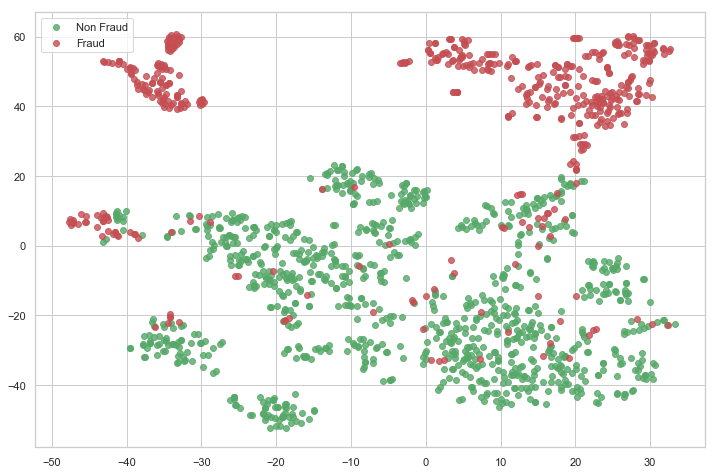

In [36]:
tsne_plot(X, Y, name="original.png")

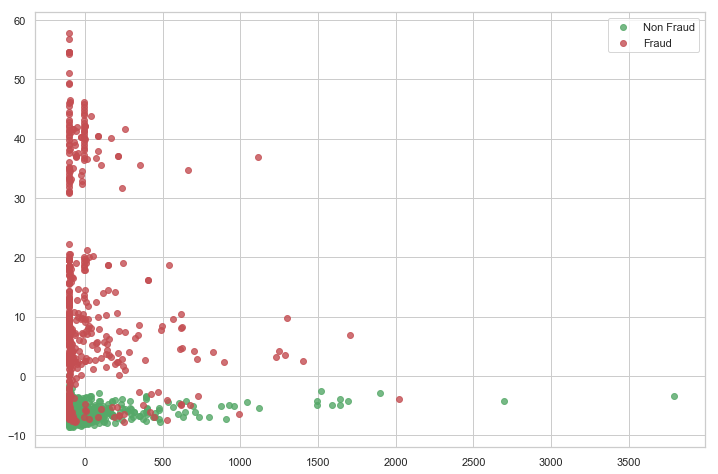

In [17]:
PCA_plot(X, Y, name="original.png")

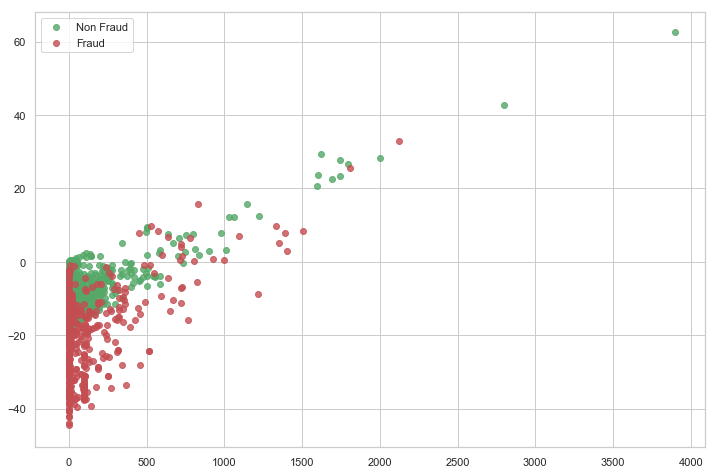

In [15]:
TruncatedSVD_plot(X, Y, name="original.png")

In [73]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

In [74]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

In [75]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

In [107]:
autoencoder.fit(x_norm, x_norm, 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20)

Train on 227452 samples, validate on 56863 samples
Epoch 1/10
227452/227452 [==============================] - 2s 10us/step - loss: 0.1224 - val_loss: 0.0963
Epoch 2/10
227452/227452 [==============================] - 2s 10us/step - loss: 0.1388 - val_loss: 0.0940
Epoch 3/10
227452/227452 [==============================] - 2s 9us/step - loss: 0.1496 - val_loss: 0.0944
Epoch 4/10
227452/227452 [==============================] - 2s 9us/step - loss: 0.1582 - val_loss: 0.0964
Epoch 5/10
227452/227452 [==============================] - 2s 9us/step - loss: 0.1656 - val_loss: 0.0964
Epoch 6/10
227452/227452 [==============================] - 2s 9us/step - loss: 0.1722 - val_loss: 0.0970
Epoch 7/10
227452/227452 [==============================] - 2s 10us/step - loss: 0.1782 - val_loss: 0.0999
Epoch 8/10
227452/227452 [==============================] - 2s 10us/step - loss: 0.1838 - val_loss: 0.1003
Epoch 9/10
227452/227452 [==============================] - 2s 10us/step - loss: 0.1889 - val_los

In [108]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [109]:
norm_hid_rep = hidden_representation.predict(x_norm[2000:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

In [110]:
len(x_norm)

284315

In [111]:
len(x_fraud)

492

In [112]:
#predict
norm_hid_rep = hidden_representation.predict(x_norm)
fraud_hid_rep = hidden_representation.predict(x_fraud)
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [ ]:
tsne_plot(rep_x, rep_y, "latent_representation.png")

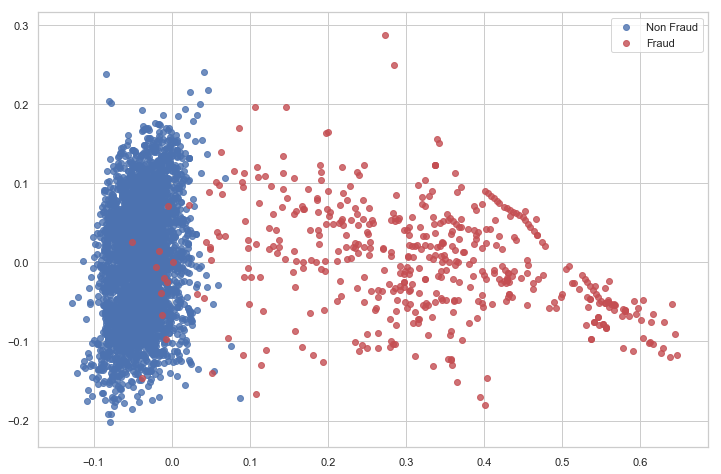

In [83]:
PCA_plot(rep_x, rep_y, name="latent_representation.png")

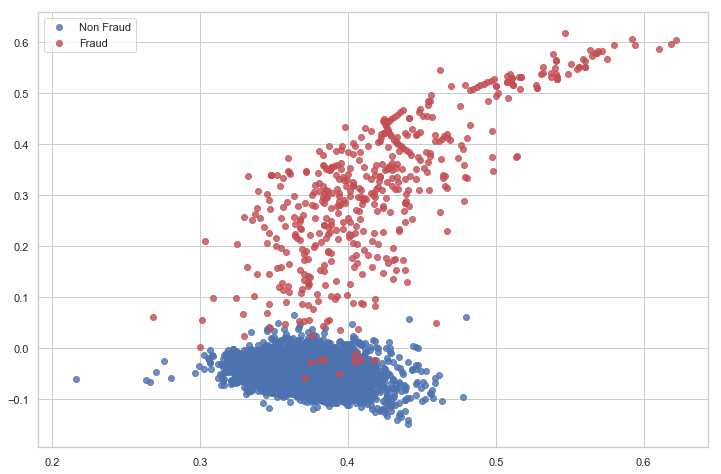

In [84]:
TruncatedSVD_plot(rep_x, rep_y, name="latent_representation.png")

In [47]:
norm_hid_rep.shape

(1000, 50)

In [105]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       259
         1.0       1.00      0.91      0.95       114

   micro avg       0.97      0.97      0.97       373
   macro avg       0.98      0.96      0.97       373
weighted avg       0.97      0.97      0.97       373


Accuracy Score:  0.9731903485254692


In [96]:
train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       249
           1       0.98      0.86      0.92       124

   micro avg       0.95      0.95      0.95       373
   macro avg       0.96      0.93      0.94       373
weighted avg       0.95      0.95      0.95       373


Accuracy Score:  0.9490616621983914
